A rough copy of https://pyimagesearch.com/2021/10/25/training-a-dcgan-in-pytorch/

In [1]:
import numpy as np
from tqdm import trange
from tinygrad import Tensor, nn
import matplotlib.pyplot as plt
from extra.datasets import fetch_mnist

In [2]:
Tensor.manual_seed(1337)

In [3]:
class Generator:
    def __init__(self):
        self.ct1 = nn.ConvTranspose2d(100, 128, 4, stride=2, bias=False)
        self.bn1 = nn.BatchNorm2d(128)
        self.ct2 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.ct3 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(32)
        self.ct4 = nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1, bias=False)
    
    def __call__(self, x):
        x = self.bn1(self.ct1(x).relu())
        x = self.bn2(self.ct2(x).relu())
        x = self.bn3(self.ct3(x).relu())
        x = self.ct4(x).tanh()
        return x

In [4]:
class Discriminator:
    def __init__(self):
        self.conv1 = nn.Conv2d(1, 32, 4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1)
        self.l1 = nn.Linear(3136, 512)
        self.l2 = nn.Linear(512, 1)
    
    def __call__(self, x):
        x = self.conv1(x).leakyrelu(0.2)
        x = self.conv2(x).leakyrelu(0.2)
        x = x.reshape(x.shape[0], -1)
        x = self.l1(x).leakyrelu(0.2)
        x = self.l2(x).sigmoid()
        return x

In [5]:
def criterion(x, y):
    return -(y * x.log() + (1 - y) * (1 - x).log()).mean()


def train_generator(discriminator, fake_data, optimizer):
    labels = Tensor.ones(fake_data.shape[0])
    output = discriminator(fake_data).reshape(-1)
    loss = criterion(output, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.numpy().item()


def train_discriminator(discriminator, real_data, fake_data, optimizer):
    real_output = discriminator(real_data).reshape(-1)
    fake_output = discriminator(fake_data).reshape(-1)
    real_labels = Tensor.ones(fake_data.shape[0])
    fake_labels = Tensor.zeros(fake_data.shape[0])
    real_loss = criterion(real_output, real_labels)
    fake_loss = criterion(fake_output, fake_labels)
    optimizer.zero_grad()
    real_loss.backward()
    fake_loss.backward()
    optimizer.step()
    return (real_loss + fake_loss).numpy().item()

In [6]:
epochs, batch_size = 20, 64
sample_interval = epochs // 4
glr, dlr = 2e-5, 7e-6
gwd, dwd = glr / epochs, dlr / epochs

In [7]:
X = np.vstack(fetch_mnist()[::2]).reshape(-1, 1, 28, 28) / 255.0
steps = X.shape[0] // batch_size
benchmark_noise = Tensor.randn(20, 100, 1, 1, requires_grad=False)

In [8]:
generator, discriminator = Generator(), Discriminator()
optimizer_g = nn.optim.AdamW(nn.state.get_parameters(generator), lr=glr, wd=gwd)
optimizer_d = nn.optim.AdamW(nn.state.get_parameters(discriminator), lr=dlr, wd=dwd)

g_loss 1.44 d_loss 0.70: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1093/1093 [00:56<00:00, 19.30it/s]


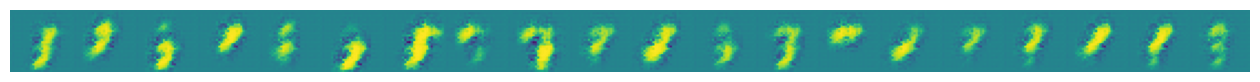

g_loss 1.64 d_loss 0.54:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1028/1093 [00:53<00:03, 19.63it/s]

In [ ]:
for i in range(epochs):
    for _ in (t := trange(steps)):
        sample = np.random.randint(0, X.shape[0], size=(batch_size))
        real_images = Tensor(X[sample], requires_grad=False)
        fake_images = generator(Tensor.randn(batch_size, 100, 1, 1))
        d_loss = train_discriminator(discriminator, real_images, fake_images.detach(), optimizer_d)
        g_loss = train_generator(discriminator, fake_images, optimizer_g)
        t.set_description(f"g_loss {g_loss:.2f} d_loss {d_loss:.2f}")
    if (i + 1) % sample_interval == 0:
        plt.figure(figsize=(16, 5))
        images = generator(benchmark_noise).detach().numpy()
        plt.imshow(np.hstack(images.reshape(-1, 28, 28)))
        plt.axis("off")
        plt.show()